In [1]:
import os
import sys
import re
import gc
from os.path import join

import torch
import anndata
import numpy as np
import pandas as pd
import xgboost as xgb
import dask.dataframe as dd
import lightning.pytorch as pl
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from emb_cellnet.estimators import EstimatorCellTypeClassifier
from emb_cellnet.models import TabnetClassifier, LinearClassifier, MLPClassifier

sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-devel/notebooks/model_evaluation")
from utils import correct_labels, get_best_ckpts, macro_f1_per_group, BIONETWORK_GROUPING

/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/tritonclient/grpc/service_pb2_grpc.py:21: RuntimeWarning: The grpc package installed is at version 1.62.2, but the generated code in grpc_service_pb2_grpc.py depends on grpcio>=1.65.5. Please upgrade your grpc module to grpcio>=1.65.5 or downgrade your generated code using grpcio-tools<=1.62.2. This warning will become an error in 1.66.0, scheduled for release on August 6, 2024.
  warnings.warn(
2025-11-23 15:46:27.453648: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Setting mean embedding for test

In [3]:
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Embedding'

test_emb = torch.load(join(DATA_PATH, "test_embedding.pt"), weights_only=True)
x_test = test_emb["X"]
y_test = test_emb["y_true"]
y_test_numpy = y_test.cpu().numpy()
unique_test_labels = torch.unique(y_test)

In [4]:
torch.manual_seed(42)  # for reproducibility
sample_size = 300 
z0_obs_all = []
y_obs_all = []

for class_idx, label in enumerate(unique_test_labels):
    class_idxs = np.where(y_test_numpy == label.item())[0]
    n_class = len(class_idxs)

    if n_class > sample_size:
        idx = torch.randperm(n_class)[:sample_size]
        selected_idxs = torch.tensor(class_idxs)[idx]
    else:
        selected_idxs = torch.tensor(class_idxs)

    z0_obs_class = x_test[selected_idxs].to(device)
    y_class = y_test[selected_idxs].to(device)

    z0_obs_all.append(z0_obs_class)
    y_obs_all.append(y_class)

# Concatenate across all classes
z0_obs_all = torch.cat(z0_obs_all, dim=0)   # shape: (sum(selected per class), latent_dim)
y_obs_all = torch.cat(y_obs_all, dim=0)     # shape: (sum(selected per class),)

print(f"[INFO] Total selected samples: {z0_obs_all.shape[0]} across {len(unique_test_labels)} classes.")

[INFO] Total selected samples: 49046 across 164 classes.


In [5]:
z0_obs_all_np = z0_obs_all.cpu().numpy()  # shape: (n_samples, n_features)

In [6]:
y_true = y_obs_all.cpu().numpy()

In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from os.path import join

# Load mapping
DATA_PATH = "/projects/b1042/GoyalLab/jaekj/merlin_cxg_2023_05_15_sf-log1p"
cell_type_mapping = pd.read_parquet(join(DATA_PATH, "categorical_lookup/cell_type.parquet"))

# --- Ensure labels are correctly mapped ---
# If y_all_np contains category indices, map them to category names
if isinstance(y_true, torch.Tensor):
    y_true_np = y_true.cpu().numpy()
else:
    y_true_np = np.asarray(y_true)

if np.issubdtype(y_true_np.dtype, np.integer):
    # Integer indices → use directly
    labels = y_true_np.astype(np.int64)
else:
    # Strings or mixed → convert to category codes
    labels = pd.Series(y_true_np).astype("category").cat.codes.to_numpy(dtype=np.int64)


# --- Dataset class ---
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels=None):
        self.embeddings = torch.as_tensor(embeddings, dtype=torch.float32)
        if labels is not None:
            # Convert to torch tensor (keep as long tensor for classification)
            self.labels = torch.as_tensor(labels, dtype=torch.long)
        else:
            self.labels = None
        self.partition_lens = [len(embeddings)]

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        if self.labels is not None:
            return {'X': x, 'cell_type': self.labels[idx]}
        return {'X': x}

# Create dataset + loader
custom_dataset = EmbeddingDataset(z0_obs_all_np, labels=labels)
custom_loader = DataLoader(custom_dataset, batch_size=2048, shuffle=False)

In [8]:
from lightning.pytorch import Trainer
import os

import sys
sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL")
from emb_cellnet.estimators import EstimatorCellTypeClassifier

# Recreate the estimator
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/merlin_cxg_2023_05_15_sf-log1p'
estim = EstimatorCellTypeClassifier(DATA_PATH, embedding=True)

class EmbeddingDataModule:
    def __init__(self, train_emb, val_emb, test_emb, batch_size=2048):
        self.train_dataset = EmbeddingDataset(train_emb['X'], train_emb['y_true'])
        self.val_dataset = EmbeddingDataset(val_emb['X'], val_emb['y_true'])
        self.test_dataset = EmbeddingDataset(test_emb['X'], test_emb['y_true'])
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

DATA_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Embedding"
train_emb = torch.load(join(DATA_PATH, "train_embedding.pt"), weights_only=True)
val_emb = torch.load(join(DATA_PATH, "val_embedding.pt"), weights_only=True)
test_emb = torch.load(join(DATA_PATH, "test_embedding.pt"), weights_only=True)

estim.datamodule = EmbeddingDataModule(train_emb, val_emb, test_emb, batch_size=2048)

### Linear Model

In [9]:
lin_model = estim
# Initialize model first with same args used for training
suggested_lr_lin = 0.019952623149688778
lin_model.init_model(
    model_type='linear',
    model_kwargs={
        'learning_rate': suggested_lr_lin,
        'weight_decay': 0.05,
        'optimizer': torch.optim.AdamW,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {'step_size': 3, 'gamma': 0.9, 'verbose': True},
    },
)

import lightning.pytorch as pl

# Minimal trainer for inference
lin_model.trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=1,
)

# Load weights
CHECKPOINT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/emb_tb_logs/linear/run1/cxg_2023_05_15_linear/default/version_1/checkpoints"
best_ckpt_path = os.path.join(
    CHECKPOINT_PATH,
    "val_f1_macro_epoch=10_val_f1_macro=0.838.ckpt"  # pick the actual best one
)
model_kwargs = lin_model.get_fixed_model_params('linear')
lin_model.model = LinearClassifier.load_from_checkpoint(best_ckpt_path, **model_kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fil

In [10]:
probas = lin_model.predict(dataloader=custom_loader)
y_pred_lin = np.argmax(probas, axis=1)

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 39.14it/s]


### scTab

In [11]:
scTab = estim

# Initialize model first with same args used for training
suggested_lr_scTab = 0.019952623149688778
scTab.init_model(
    model_type='tabnet',
    model_kwargs={
        'learning_rate': suggested_lr_scTab,
        'weight_decay': 0.05,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {
            'step_size': 2,
            'gamma': 0.9,
            'verbose': True
        },
        'optimizer': torch.optim.AdamW,
        'lambda_sparse': 1e-5,
        'n_d': 128,
        'n_a': 64,
        'n_steps': 1,
        'gamma': 1.3,
        'n_independent': 7,
        'n_shared': 3,
        'virtual_batch_size': 256,
        'mask_type': 'entmax',
        'augment_training_data': False
    },
)
import lightning.pytorch as pl

# Minimal trainer for inference
scTab.trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=1,
)

CHECKPOINT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/emb_tb_logs/tabnet/cxg_2023_05_15_lung_only_tabnet/default/version_2_no_augment/checkpoints"
best_ckpt_path = os.path.join(
    CHECKPOINT_PATH,
    "val_f1_macro_epoch=49_val_f1_macro=0.843.ckpt"  # pick the actual best one
)
# Load weights
model_kwargs = scTab.get_fixed_model_params('tabnet')
scTab.model = TabnetClassifier.load_from_checkpoint(best_ckpt_path, **model_kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fil

In [12]:
probas = scTab.predict(dataloader=custom_loader)
y_pred_tab = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 24/24 [00:02<00:00, 11.02it/s]


### MLP

In [13]:
suggested_lr_mlp = 0.030199517204020147

In [14]:
mlp = estim

mlp.init_model(
    model_type='mlp',
    model_kwargs={
        'learning_rate': 0.002,
        'weight_decay': 0.05,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {
            'step_size': 1,
            'gamma': 0.9,
            'verbose': True
        },
        'optimizer': torch.optim.AdamW,
        'n_hidden': 8,
        'hidden_size': 128,
        'dropout': 0.1,
        'augment_training_data': False},
)
import lightning.pytorch as pl

# Minimal trainer for inference
mlp.trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=1,
)

# Load weights
CHECKPOINT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/emb_tb_logs/mlp/run1/mlp/default/version_7/checkpoints"
best_ckpt_path = os.path.join(
    CHECKPOINT_PATH,
    "val_f1_macro_epoch=42_val_f1_macro=0.842.ckpt"  # pick the actual best one
)
model_kwargs = mlp.get_fixed_model_params('mlp')
mlp.model = MLPClassifier.load_from_checkpoint(best_ckpt_path, **model_kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded fil

In [15]:
probas = mlp.predict(dataloader=custom_loader)
y_pred_mlp = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 26.51it/s]


### Logistic Regression

In [ ]:
!pip show scikit-learn

In [16]:
from sklearn.linear_model import SGDClassifier
import joblib

lr_CKPT_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/emb_tb_logs/LogisticRegression/run1/logistic_regression_clf.pkl"

lr_clf = joblib.load(lr_CKPT_PATH)
lr_clf

SGDClassifier(loss='log', random_state=1)

In [17]:
y_pred_lr = lr_clf.predict(z0_obs_all_np)

### XGBoost

In [18]:
xgb_CKPT_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_XGBoost/run1/xgb_embedding_model.json'

In [19]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.load_model(xgb_CKPT_PATH)
xgb_clf.set_params(predictor='gpu_predictor')
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=0.075,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=20, num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, ...)

In [20]:
y_pred_xgb = xgb_clf.predict(z0_obs_all_np)

### Softmax

In [21]:
import os
import numpy as np

SAVE_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/Uncertainty_Rand_300_T_1000_Path_4/class_results"

def class_numeric_key(folder_name):
    # extract integer after "class_"
    return int(folder_name.split("_")[1])

y_true_all = []
y_pred_all = []
posteriors_all = []

# sort by numeric class index
for class_dir in sorted(os.listdir(SAVE_PATH), key=class_numeric_key):
    if not class_dir.startswith("class"):
        continue
    class_path = os.path.join(SAVE_PATH, class_dir)
    y_true_sm = np.load(os.path.join(class_path, "y_true.npy"))
    y_pred_sm = np.load(os.path.join(class_path, "y_pred.npy"))

    y_true_all.append(y_true_sm)
    y_pred_all.append(y_pred_sm)

y_true_softmax = np.concatenate(y_true_all)
y_pred_softmax = np.concatenate(y_pred_all)

print("Total samples:", len(y_true_softmax))

Total samples: 49046


In [22]:
y_true

array([  0,   0,   0, ..., 163, 163, 163])

In [23]:
y_true.flatten()          # from (N,1) -> (N,)

array([  0,   0,   0, ..., 163, 163, 163])

In [24]:
y_true_softmax

array([  0,   0,   0, ..., 163, 163, 163])

In [25]:
assert (y_true.flatten() == y_true_softmax).all(), "Mismatch detected: y_true and y_true_softmax contain different values"

In [26]:
import os
import numpy as np

SAVE_PATH = "/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/Model_softmax/Uncertainty_Rand_300_T_1000_Path_4/class_results"


def class_numeric_key(folder_name):
    return int(folder_name.split("_")[1])


# ----------------------------------------
# Load ALL classes
# ----------------------------------------
y_true_list = []
y_pred_list = []
post_mean_list = []
post_sem_list = []

class_folders = sorted(
    [d for d in os.listdir(SAVE_PATH) if d.startswith("class_")],
    key=class_numeric_key
)

for class_dir in class_folders:
    class_path = os.path.join(SAVE_PATH, class_dir)

    # Load the first 200 samples per class (your rule)
    y_true = np.load(os.path.join(class_path, "y_true.npy"))
    y_pred = np.load(os.path.join(class_path, "y_pred.npy"))
    post_mean = np.load(os.path.join(class_path, "posteriors_mean.npy"))
    post_sem  = np.load(os.path.join(class_path, "posteriors_sem.npy"))

    y_true_list.append(y_true)
    y_pred_list.append(y_pred)
    post_mean_list.append(post_mean)
    post_sem_list.append(post_sem)


# ----------------------------------------
# Final concatenated arrays
# ----------------------------------------
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
posteriors_mean = np.concatenate(post_mean_list)  # shape [N, num_classes]
posteriors_sem = np.concatenate(post_sem_list)    # shape [N, num_classes]

print("Loaded samples:", len(y_true))
print("posteriors_mean shape:", posteriors_mean.shape)
print("posteriors_sem shape:", posteriors_sem.shape)

Loaded samples: 49046
posteriors_mean shape: (49046, 164)
posteriors_sem shape: (49046, 164)


In [27]:
# Use mean + SEM arrays generated by your new inference script
y_true_arr = y_true               # shape [N]
y_pred_arr = y_pred               # shape [N]
post_mean_arr = posteriors_mean   # shape [N, num_classes]
post_sem_arr  = posteriors_sem    # shape [N, num_classes]

y_pred_adjusted = y_pred_arr.copy()

for i in range(len(y_true_arr)):
    true_label = y_true_arr[i]
    
    posterior_mean = post_mean_arr[i]   # [num_classes]
    posterior_sem  = post_sem_arr[i]    # [num_classes]
    
    max_post = posterior_mean.max()
    
    # UNCERTAINTY RULE:
    # true class is considered correct if:
    # posterior_mean(true) >= max(posterior_mean) - SEM(true)
    if posterior_mean[true_label] >= max_post - posterior_sem[true_label]:
        y_pred_adjusted[i] = true_label

In [28]:
from sklearn.metrics import f1_score

f1_original = f1_score(y_true_arr, y_pred_arr, average="macro")
f1_adjusted = f1_score(y_true_arr, y_pred_adjusted, average="macro")

print("Original macro F1:", f1_original)
print("Adjusted macro F1:", f1_adjusted)

Original macro F1: 0.8283231550924331
Adjusted macro F1: 0.8377792632559925


In [29]:
y_true = np.asarray(y_true, dtype=np.int64).ravel()
y_pred_lin = np.asarray(y_pred_lin, dtype=np.int64).ravel()
y_pred_tab = np.asarray(y_pred_tab, dtype=np.int64).ravel()
y_pred_mlp = np.asarray(y_pred_mlp, dtype=np.int64).ravel()
y_pred_lr = np.asarray(y_pred_lr, dtype=np.int64).ravel()
y_pred_xgb = np.asarray(y_pred_xgb, dtype=np.int64).ravel()
y_pred_softmax = np.asarray(y_pred_softmax, dtype=np.int64).ravel()
y_pred_softmax_adjusted = np.asarray(y_pred_adjusted, dtype=np.int64).ravel()

# Comparison

In [30]:
y_true.shape

(49046,)

In [31]:
from sklearn.metrics import f1_score
import numpy as np

# Compute macro F1 once per model
f1_lin = f1_score(y_true, y_pred_lin, average="macro")
f1_tab = f1_score(y_true, y_pred_tab, average="macro")
f1_mlp = f1_score(y_true, y_pred_mlp, average="macro")
f1_xgb = f1_score(y_true, y_pred_xgb, average="macro")
f1_lr = f1_score(y_true, y_pred_lr, average="macro")
f1_softmax = f1_score(y_true, y_pred_softmax, average="macro")
f1_softmax_adj = f1_score(y_true, y_pred_softmax_adjusted, average="macro")

print(f"Linear F1: {f1_lin:.3f}")
print(f"scTab F1: {f1_tab:.3f}")
print(f"mlp F1: {f1_mlp:.3f}")
print(f"XGB F1: {f1_xgb:.3f}")
print(f"LR F1: {f1_lr:.3f}")
print(f"Softmax F1: {f1_softmax:.3f}")
print(f"Softmax_adjusted F1: {f1_softmax_adj:.3f}")

Linear F1: 0.831
scTab F1: 0.832
mlp F1: 0.832
XGB F1: 0.818
LR F1: 0.808
Softmax F1: 0.828
Softmax_adjusted F1: 0.838


In [32]:
from sklearn.metrics import f1_score

macro_f1 = {
    "Linear": f1_score(y_true, y_pred_lin, average="macro"),
    "scTab": f1_score(y_true, y_pred_tab, average="macro"),
    "MLP": f1_score(y_true, y_pred_mlp, average="macro"),
    "XGB": f1_score(y_true, y_pred_xgb, average="macro"),
    "LR":  f1_score(y_true, y_pred_lr,  average="macro"),
    "Softmax": f1_score(y_true, y_pred_softmax, average="macro"),
    "Softmax_adj": f1_score(y_true, y_pred_softmax_adjusted, average="macro"),
}

In [37]:
from sklearn.metrics import f1_score

f1_lin_pc = f1_score(y_true, y_pred_lin, average=None)
f1_tab_pc = f1_score(y_true, y_pred_tab, average=None)
f1_mlp_pc = f1_score(y_true, y_pred_mlp, average=None)
f1_xgb_pc = f1_score(y_true, y_pred_xgb, average=None)
f1_lr_pc  = f1_score(y_true, y_pred_lr,  average=None)
# f1_soft_pc = f1_score(y_true, y_pred_softmax, average=None)
f1_soft_pc_adj = f1_score(y_true, y_pred_softmax_adjusted, average=None)

In [38]:
import pandas as pd
import numpy as np

models = ["LR", "XGB", "Linear", "scTab", "MLP", "Softmax_adj"]
all_scores = [f1_lr_pc, f1_xgb_pc, f1_lin_pc, f1_tab_pc, f1_mlp_pc, f1_soft_pc_adj]

df = pd.DataFrame({
    "model": np.repeat(models, [len(s) for s in all_scores]),
    "F1": np.concatenate(all_scores)
})

/tmp/ipykernel_2659162/2751001292.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


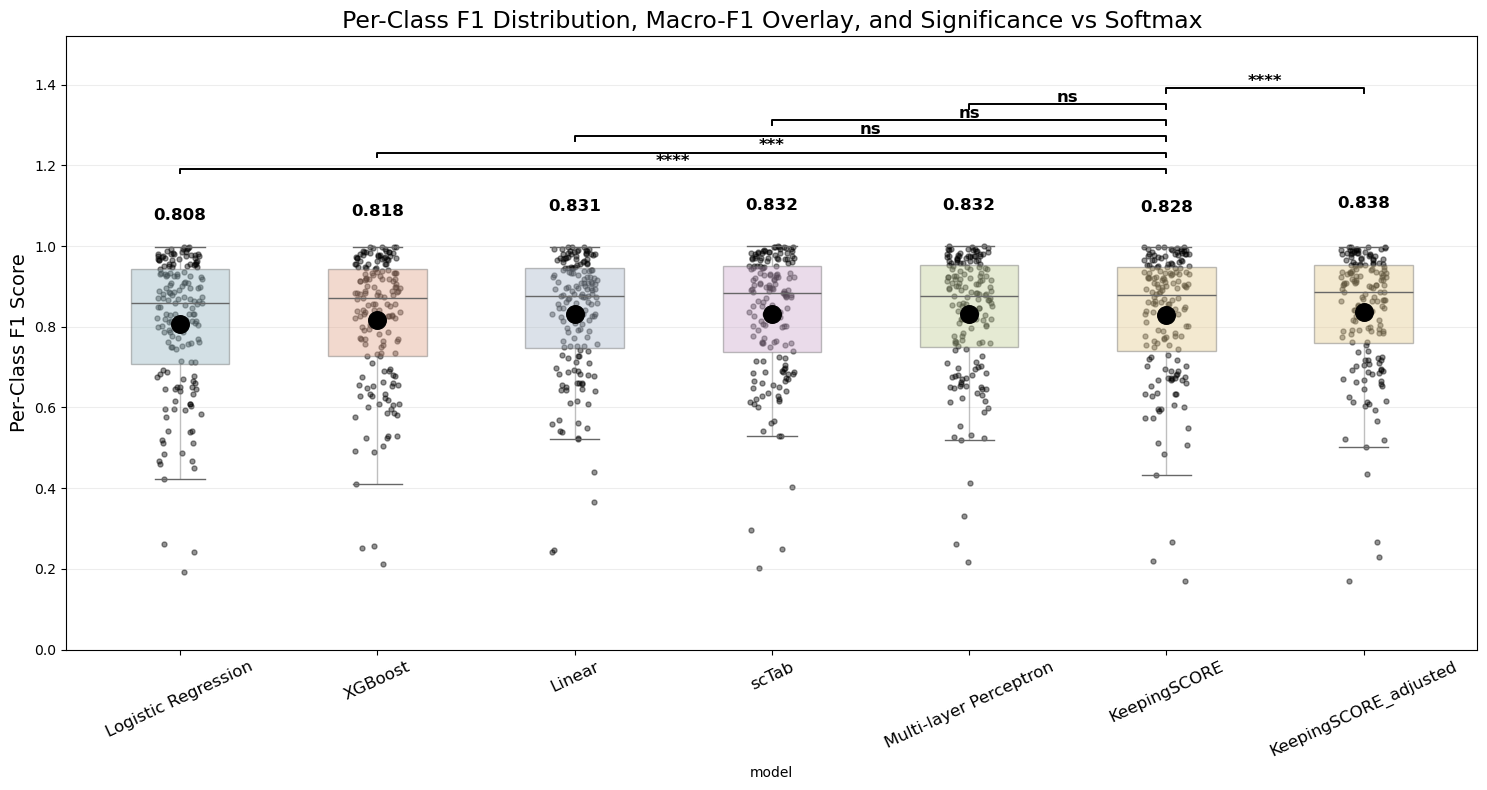

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smm

# --------------------------------------------------------------------------
# SIGNIFICANCE TESTING vs Softmax
# --------------------------------------------------------------------------
soft = f1_soft_pc
p_raw = []

for m, scores in zip(models, all_scores):
    if m == "Softmax":
        p_raw.append(np.nan)
        continue
    stat, p = wilcoxon(scores, soft)
    p_raw.append(p)

# FDR correction
p_vals = np.array([p if not np.isnan(p) else np.nan for p in p_raw])
mask = ~np.isnan(p_vals)
p_corrected = p_vals.copy()
p_corrected[mask] = smm.multipletests(p_vals[mask], method='fdr_bh')[1]


# --------------------------------------------------------------------------
# SIGNIFICANCE BAR HELPER
# --------------------------------------------------------------------------
def significance_annotation(p):
    if p < 0.0001: return "****"
    elif p < 0.001: return "***"
    elif p < 0.01:  return "**"
    elif p < 0.05:  return "*"
    else:           return "ns"


# --------------------------------------------------------------------------
# PLOT
# --------------------------------------------------------------------------
plt.figure(figsize=(15,8))

# Custom subtle palette
palette = [
    "#8FBBC8",  # teal
    "#F0A17E",  # orange
    "#A6B8D0",  # blue
    "#D3A5D4",  # lavender
    "#C6D68F",  # green
    "#F2D082",   # soft gold (Softmax)
    "#F2D082"   # soft gold (Softmax)
]

# 1) Boxplot
sns.boxplot(
    data=df, x="model", y="F1",
    showcaps=True, fliersize=0,
    boxprops=dict(alpha=0.42),
    width=0.5,                     # <<< ADD THIS
    whiskerprops=dict(alpha=0.42),
    palette=palette
)

# 2) Dotplot (jittered)
for i, model in enumerate(models):
    scores = df[df["model"] == model]["F1"].values
    jitter = (np.random.rand(len(scores)) - 0.5) * 0.23
    plt.scatter(
        np.ones_like(scores)*i + jitter,
        scores,
        alpha=0.42, s=13, color="black"
    )


# 3) Macro-F1 overlay (diamond)
for i, m in enumerate(models):
    plt.scatter(
        i, macro_f1[m],
        color="black",
        s=160, marker="o",
        edgecolor="black", linewidth=1.0,
        zorder=10
    )
    # label the macro-F1 value
    plt.text(
        i, macro_f1[m] + 0.25,
        f"{macro_f1[m]:.3f}",
        ha='center', va='bottom',
        fontsize=12, fontweight='bold'
    )


# --------------------------------------------------------------------------
# SIGNIFICANCE BARS vs Softmax
# --------------------------------------------------------------------------
soft_idx = models.index("Softmax")
y_top = df["F1"].max() + 0.18
step = 0.04
cur_y = y_top

for i, m in enumerate(models):
    if m == "Softmax": 
        continue

    p = p_corrected[i]
    if np.isnan(p): 
        continue

    annot = significance_annotation(p)

    x1, x2 = i, soft_idx
    plt.plot([x1, x1, x2, x2],
             [cur_y, cur_y+0.012, cur_y+0.012, cur_y],
             lw=1.4, color='black')

    plt.text(
        (x1 + x2)/2, cur_y + 0.018,
        annot,
        ha='center', fontsize=12, fontweight='bold'
    )

    cur_y += step

# --------------------------------------------------------------------------
# FINAL FORMATTING
# --------------------------------------------------------------------------
model_names = [
    "Logistic Regression", "XGBoost", "Linear", "scTab", "Multi-layer Perceptron", "KeepingSCORE", "KeepingSCORE_adjusted"
]

plt.xticks(range(len(models)), model_names, rotation=25, fontsize=12)
plt.ylabel("Per-Class F1 Score", fontsize=14)
plt.title("Per-Class F1 Distribution, Macro-F1 Overlay, and Significance vs Softmax", fontsize=17)

plt.ylim(0, cur_y + 0.1)
plt.grid(axis='y', alpha=0.22)

plt.tight_layout()
# plt.savefig("result_new_model.png", dpi=300)
# plt.savefig("result_new_model.svg")

plt.show()

/tmp/ipykernel_2023857/506962642.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2023857/506962642.py:70: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.boxplot(


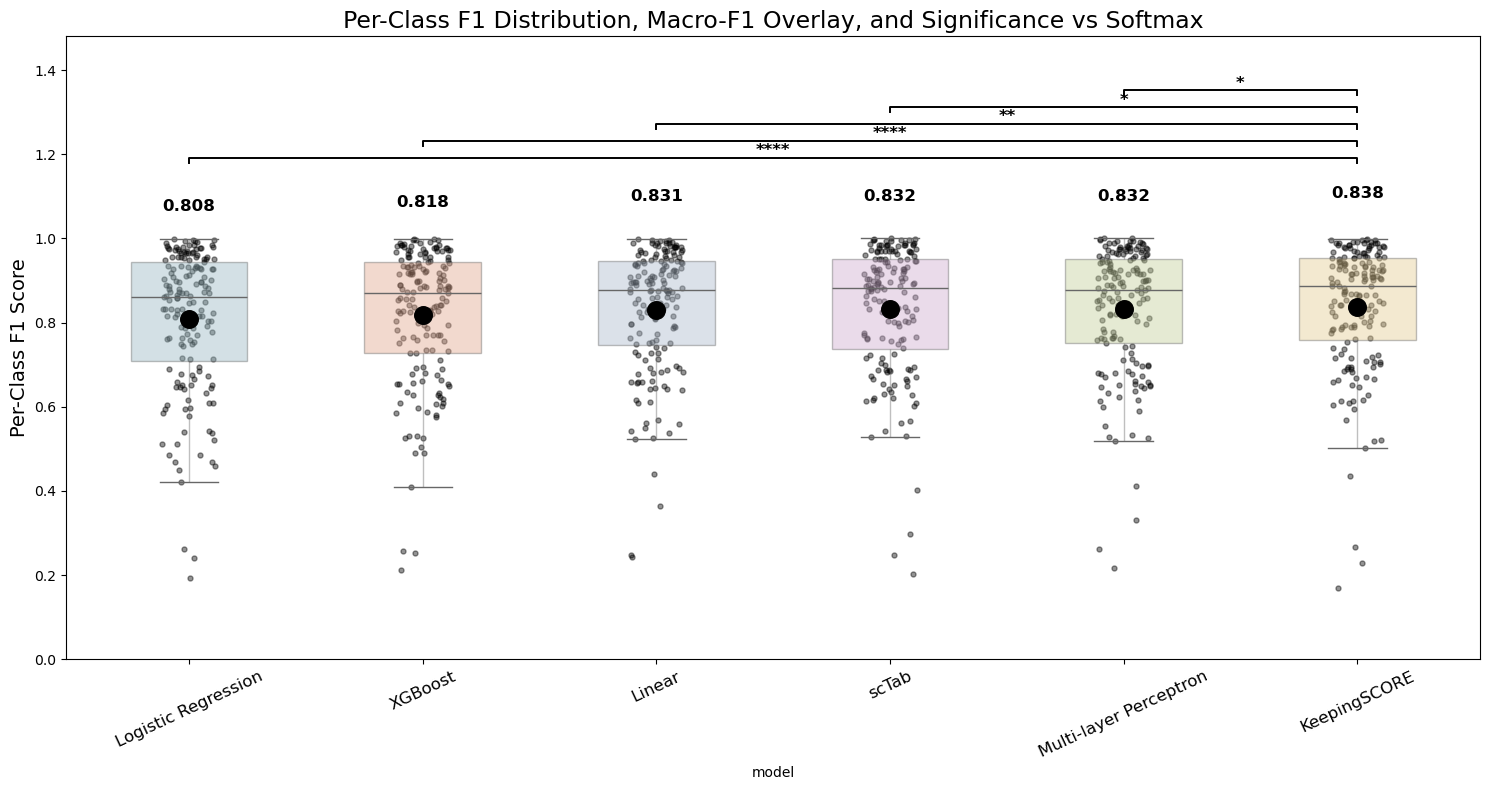

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smm

# --------------------------------------------------------------------------
# SIGNIFICANCE TESTING vs KeepingSCORE_adjusted
# --------------------------------------------------------------------------
soft = f1_soft_pc_adj
ref_model = "KeepingSCORE_adjusted"

p_raw = []
for m, scores in zip(models, all_scores):

    # skip itself
    if m == ref_model:
        p_raw.append(np.nan)
        continue
    
    # skip models identical to the reference (Wilcoxon cannot run)
    if np.allclose(scores, soft):
        p_raw.append(np.nan)
        continue

    # safe Wilcoxon
    stat, p = wilcoxon(scores, soft, zero_method="zsplit")
    p_raw.append(p)

# FDR correction
p_vals = np.array([p if not np.isnan(p) else np.nan for p in p_raw])
mask = ~np.isnan(p_vals)
p_corrected = p_vals.copy()
p_corrected[mask] = smm.multipletests(p_vals[mask], method='fdr_bh')[1]



# --------------------------------------------------------------------------
# SIGNIFICANCE BAR HELPER
# --------------------------------------------------------------------------
def significance_annotation(p):
    if p < 0.0001: return "****"
    elif p < 0.001: return "***"
    elif p < 0.01:  return "**"
    elif p < 0.05:  return "*"
    else:           return "ns"


# --------------------------------------------------------------------------
# PLOT
# --------------------------------------------------------------------------
plt.figure(figsize=(15,8))

# Custom subtle palette
palette = [
    "#8FBBC8",  # teal
    "#F0A17E",  # orange
    "#A6B8D0",  # blue
    "#D3A5D4",  # lavender
    "#C6D68F",  # green
    "#F2D082",   # soft gold (Softmax)
    "#F2D082"   # soft gold (Softmax)
]

# 1) Boxplot
sns.boxplot(
    data=df, x="model", y="F1",
    showcaps=True, fliersize=0,
    boxprops=dict(alpha=0.42),
    width=0.5,                     # <<< ADD THIS
    whiskerprops=dict(alpha=0.42),
    palette=palette
)

# 2) Dotplot (jittered)
for i, model in enumerate(models):
    scores = df[df["model"] == model]["F1"].values
    jitter = (np.random.rand(len(scores)) - 0.5) * 0.23
    plt.scatter(
        np.ones_like(scores)*i + jitter,
        scores,
        alpha=0.42, s=13, color="black"
    )


# 3) Macro-F1 overlay (diamond)
for i, m in enumerate(models):
    plt.scatter(
        i, macro_f1[m],
        color="black",
        s=160, marker="o",
        edgecolor="black", linewidth=1.0,
        zorder=10
    )
    # label the macro-F1 value
    plt.text(
        i, macro_f1[m] + 0.25,
        f"{macro_f1[m]:.3f}",
        ha='center', va='bottom',
        fontsize=12, fontweight='bold'
    )


# --------------------------------------------------------------------------
# SIGNIFICANCE BARS vs KeepingSCORE_adjusted
# --------------------------------------------------------------------------
ref_idx = models.index("Softmax_adj")
y_top = df["F1"].max() + 0.18
step = 0.04
cur_y = y_top

for i, m in enumerate(models):
    if m == ref_model:
        continue

    p = p_corrected[i]
    if np.isnan(p):
        continue
    
    annot = significance_annotation(p)

    x1, x2 = i, ref_idx
    plt.plot([x1, x1, x2, x2],
             [cur_y, cur_y+0.012, cur_y+0.012, cur_y],
             lw=1.4, color='black')

    plt.text(
        (x1 + x2) / 2, cur_y + 0.018,
        annot,
        ha='center', fontsize=12, fontweight='bold'
    )

    cur_y += step


# --------------------------------------------------------------------------
# FINAL FORMATTING
# --------------------------------------------------------------------------
model_names = [
    "Logistic Regression", "XGBoost", "Linear", "scTab", "Multi-layer Perceptron", "KeepingSCORE", 
    # "KeepingSCORE_adjusted"
]

plt.xticks(range(len(models)), model_names, rotation=25, fontsize=12)
plt.ylabel("Per-Class F1 Score", fontsize=14)
plt.title("Per-Class F1 Distribution, Macro-F1 Overlay, and Significance vs Softmax", fontsize=17)

plt.ylim(0, cur_y + 0.1)
# plt.grid(axis='y', alpha=0.22)

plt.tight_layout()
plt.savefig("celltype_F1.png", dpi=150)
plt.savefig("celltype_F1.svg", dpi=150)

plt.show()

In [ ]:
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL'

test_emb = torch.load(join(DATA_PATH, "test_embedding.pt"), weights_only=True)
x_test = test_emb["X"]
y_test = test_emb["y"]
y_test_numpy = y_test.cpu().numpy()
unique_test_labels = torch.unique(y_test)